# 使用langgraph构建一个multi-agent

In [1]:
from langchain_openai import ChatOpenAI

# 读入配置文件，使用zhipuai glm-4-plus模型
import yaml

with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    config = config['zhipuai glm-4-plus']

# 初始化模型
llm = ChatOpenAI(
    model=config['model'], 
    openai_api_key=config['api_key'],
    openai_api_base=config['base_url'],
    temperature=0.1
)

## Create Agent Supervisor

It will use function calling to choose the next worker node OR finish processing.

### 定义提示词

In [2]:
from langchain.prompts import load_prompt
from langchain_core.prompts import ChatPromptTemplate

members = ['DataMiner', 'Visualizer']
options = ['FINISH'] + list(members)

system_prompt = load_prompt("prompt_templates/supervisor.yaml")

supervisor_prompt = ChatPromptTemplate([
    ("system", system_prompt.format(members=members)),
    ("placeholder", "{messages}"),
    ("system", "根据以上对话，用户的问题已有答案，如果有请选择FINISH。如果没有，请判断该由谁来进一步处理。 Select one of: {options}")
]).partial(options=str(options))

### 定义supervisor agent
chain = prompt | llm

In [3]:
from pydantic import BaseModel
from typing import Annotated, Literal

# 限制supervisor_agent的输入类型
class routeResponse(BaseModel):
    next: Annotated[Literal['FINISH', 'DataMiner', 'Visualizer'], 'Who should act next? Or should we finish?']

# supervisor_agent
def supervisor_agent(state):
    chain = (
        supervisor_prompt
        # with_strctured_output构造了一个tool，让llm进行tool_call时输入参数身体符合指定格式
        | llm.with_structured_output(routeResponse) 
    )
    return chain.invoke(state)

## Create DataMiner and Visualizer agents

### Create tools

基于pandoraBox实例化一个python 代码沙盒，在沙盒内将excel读入为Dataframe。

analyze_data用于处理数据分析任务，plot_data用于绘图。

In [4]:
from langchain_core.tools import tool
from pbox import CodeSandBox

code_sandbox = CodeSandBox()

code = """
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置为黑体
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
df = pd.read_excel('leave.xlsx')
"""

code_sandbox.execute_code(code)

def save_plot(data):
    from io import BytesIO  
    from PIL import Image  
    import base64

    image_data = data
    image_data_bytes = base64.b64decode(image_data)  
    image = Image.open(BytesIO(image_data_bytes))
    image.save('plot.png', format='PNG')

@tool
def analyze_data(
    code: Annotated[str, "A valid python command working with `df`. If you want to see the output of a value, you should print it out with `print(...)`."]
    ) -> str:
    """执行关于pandas dataframe `df`的代码，使用print() 输出结果"""
    result = code_sandbox.execute_code(code)

    if result.logs.stdout:
        output = '\n'.join(result.logs.stdout)
        return f"已得到执行结果：\n{output}"
    if result.results:
        for each in result.results:
            if each['type'] == 'image/png':
                # 保存图片文件
                save_plot(each['data'])
                return f"已保存图片，可视化任务已完成。"
            
        return f"执行出错，你是否忘记使用`print()`来打印结果？"
    elif result.error:
        import re

        # 用正则匹配ansi颜色代码后，替换为空
        pattern = r'\x1b\[\d+[;\d+]*m'
        error_message =  '\n'.join(result.error.traceback)
        output = re.sub(pattern, '', error_message)

        return f"执行出错：\n{output}"
    else:
        return f"执行出错，你是否忘记使用`print()`来打印结果？"
        


@tool
def plot_data(
    code: Annotated[str, "A valid python command using matplotlib working with `df`. Show the plot with `plt.show()`."]) -> str:
    """执行关于`df.plot`的代码，使用`plt.show()`输出结果。"""
    result = code_sandbox.execute_code(code)
    
    # 执行结果输出
    if result.results:
        for each in result.results:
            if each['type'] == 'image/png':
                # 保存图片文件
                save_plot(each['data'])
                return f"已保存图片，可视化任务已完成。"
            
        return f"执行出错，请检查你的代码。"
    elif result.error:
        import re

        # 用正则匹配ansi颜色代码后，替换为空
        pattern = r'\x1b\[\d+[;\d+]*m'
        error_message =  '\n'.join(result.error.traceback)
        output = re.sub(pattern, '', error_message)

        return f"执行出错：\n{output}"
    else:
        return str(result.json())
        
    

### Create ReAct agents

In [5]:
import functools

from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage


# Define a helper function that we will use to create the nodes in the graph
# - 将agent回复转换为HumanMessage.
# This is important because that is how we will add it the global state of the graph
def agent_node(state, agent, prompt, name):
    chain = prompt | agent
    result = chain.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}


### DataMiner Agent

In [6]:
# prompt
dhead = '\n'.join(code_sandbox.execute_code('print(df.head().to_markdown())').logs.stdout)

system_prompt = load_prompt("prompt_templates/dataminer.yaml")

prompt = ChatPromptTemplate([
    ("system", system_prompt.format(dhead=dhead)),
    ("placeholder", "{messages}")
])

# agent
dataminer_agent = create_react_agent(llm, tools=[analyze_data, plot_data])

# node
dataminer_node = functools.partial(agent_node, agent=dataminer_agent, prompt=prompt, name="DataMiner")

In [7]:
# prompt

system_prompt = load_prompt("prompt_templates/visualizer.yaml")

prompt = ChatPromptTemplate([
    ("system", system_prompt.format(dhead=dhead)),
    ("placeholder", "{messages}")
])

# agent
visualizer_agent = create_react_agent(llm, tools=[plot_data])

# node
visualizer_node = functools.partial(agent_node, agent=visualizer_agent, prompt=prompt, name="Visualizer")

## Construct Graph

We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

### 将节点添加到图

In [8]:
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START, END

# The agent state is the input to each node in the graph
# 就是比普通消息列表多一个next字段
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]

    # The 'next' field indicates where to route to next
    next: str

workflow = StateGraph(AgentState)

# 添加三个节点
workflow.add_node("Supervisor", supervisor_agent)
workflow.add_node("DataMiner", dataminer_node)
workflow.add_node("Visualizer", visualizer_node)

### 连连看！

In [9]:
# We want our workers to ALWAYS "report back" to the supervisor when done
for worker in members:
    workflow.add_edge(worker, "Supervisor")


# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], conditional_map)

# Finally, add entrypoint
workflow.add_edge(START, "Supervisor")


graph = workflow.compile()

### 可视化一下

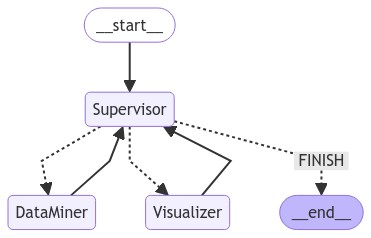

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the team

With the graph created, we can now invoke it and see how it performs!

### 设置langchain 的verbose与debug

In [11]:
from langchain.globals import set_debug, set_verbose

set_debug(False)
set_verbose(False)

### 跑一跑看看

In [12]:
query = '请假最多人叫什么'

for each in graph.stream(
    {"messages":[HumanMessage(content=query)]}, stream_mode='values'):
    each['messages'][-1].pretty_print()

================================ Human Message =================================

请假最多人叫什么
================================ Human Message =================================

请假最多人叫什么
================================ Human Message =================================
Name: DataMiner

analyze_data
```python
print(df['申请人'].value_counts().idxmax())
```
================================ Human Message =================================
Name: DataMiner

analyze_data
```python
print(df['申请人'].value_counts().idxmax())
```
================================ Human Message =================================
Name: DataMiner

请假最多的人叫张莹玺。
================================ Human Message =================================
Name: DataMiner

请假最多的人叫张莹玺。
================================ Human Message =================================
Name: DataMiner

请假最多的人叫张莹玺。


In [13]:
query = '请用饼图展示请假人数最多的5个部门'

for each in graph.stream({"messages":[HumanMessage(content=query)]}):
    print(each)

{'Supervisor': {'next': 'DataMiner'}}
{'DataMiner': {'messages': [HumanMessage(content='请假人数最多的5个部门已经通过饼图展示出来，请查看生成的图片。', name='DataMiner')]}}
{'Supervisor': {'next': 'Visualizer'}}
{'Visualizer': {'messages': [HumanMessage(content='图片已生成。', name='Visualizer')]}}
{'Supervisor': {'next': 'FINISH'}}


In [15]:
for each in graph.stream({"messages":[HumanMessage(content=query)]}, stream_mode='debug'):
    print(each)

{'type': 'task', 'timestamp': '2024-09-05T12:14:48.602733+00:00', 'step': 1, 'payload': {'id': '5ef199ff-5d1d-5b90-a619-c7e73dd3de80', 'name': 'Supervisor', 'input': {'messages': [HumanMessage(content='请用饼图展示请假人数最多的5个部门')]}, 'triggers': ['start:Supervisor']}}
{'type': 'task_result', 'timestamp': '2024-09-05T12:14:49.429065+00:00', 'step': 1, 'payload': {'id': '5ef199ff-5d1d-5b90-a619-c7e73dd3de80', 'name': 'Supervisor', 'error': None, 'result': [('next', 'DataMiner')], 'interrupts': []}}
{'type': 'task', 'timestamp': '2024-09-05T12:14:49.429574+00:00', 'step': 2, 'payload': {'id': '6931932d-e511-5e52-a2e9-08cd38193d70', 'name': 'DataMiner', 'input': {'messages': [HumanMessage(content='请用饼图展示请假人数最多的5个部门')], 'next': 'DataMiner'}, 'triggers': ['branch:Supervisor:condition:DataMiner']}}
{'type': 'task_result', 'timestamp': '2024-09-05T12:14:55.569732+00:00', 'step': 2, 'payload': {'id': '6931932d-e511-5e52-a2e9-08cd38193d70', 'name': 'DataMiner', 'error': None, 'result': [('messages', [Hum